# 🫀 Clinical-Grade ECG Model Evaluation  
<span style="color:red">by Ridwan Oladipo, MD | Medical AI Specialist</span>  

Comprehensive validation of **multimodal ECG AI** trained on **PTB-XL (21,837 recordings)** and tested on **4,396 official holdout cases** across 5 cardiac conditions.  

### 📈 Clinical-Grade Performance  
- **MI Sensitivity (Recall):** 96.2% (exceeds >95% clinical goal)  
- **MI Specificity:** 99.97%  
- **MI Precision (PPV):** 99.9%  
- **MI NPV:** 98.7% (exceeds >98% safety threshold)  
- **MI AUC:** 0.999 (near-perfect discriminative power)  
- **Calibration (Brier Score, MI):** 0.008 (excellent reliability)  
- **Macro AUC (All Classes):** 0.95  
- **Macro F1 Score:** 0.81  
- **Overall Accuracy:** 87.4%  
- **Cohen’s Kappa:** 0.82 (substantial agreement)  

### 📊 Deployment Readiness Validation  
- **Calibration analysis** → probability-risk alignment with reliability curves  
- **Demographic slice testing** → age/sex/device subgroup performance  
- **Robustness validation** → stable under ECG noise perturbations  
- **Generalization testing** → cross-site performance validation  
- **Clinical documentation** → model card with intended use and limitations  

>🎯 **Clinical impact**: Achieves **regulatory-grade reliability** and transforms ECG interpretation from **minutes of manual review** into **seconds of AI-powered screening**, with **regulatory-ready metrics** for cardiac emergency detection.

## 🧪 Environment Setup and Model Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, confusion_matrix
from sklearn.calibration import calibration_curve
import shap
import pickle
import os
import json
from scipy.ndimage import zoom
from scipy.signal import find_peaks

# Load trained model and preprocessed data
model = tf.keras.models.load_model("/kaggle/input/ecg-evaluation/ecg_resnet_multimodal_final.keras")
base_dir = "/kaggle/input/ecg-evaluation"

all_signals = np.load(f"{base_dir}/all_signals.npy", allow_pickle=True)
y_labels = np.load(f"{base_dir}/y_labels.npy", allow_pickle=True)
all_features = pd.read_parquet(f"{base_dir}/all_features.parquet")
model_df_with_labels = pd.read_parquet(f"{base_dir}/model_df_with_labels.parquet")

# Train/test split
train_idx = model_df_with_labels['strat_fold'] < 9
test_idx = model_df_with_labels['strat_fold'] >= 9

X_ecg_test = all_signals[test_idx]
X_tab_test = all_features.loc[test_idx]
y_test = y_labels[test_idx]

class_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

print("=== ECG Evaluation Environment Initialized ===")
print(f"✓ Model loaded successfully")
print(f"✓ Test set: {len(X_ecg_test):,} samples")
print(f"✓ Feature dimensions: {X_tab_test.shape}")
print(f"✓ Classes: {class_names}")


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int64)):
            return int(obj)
        if isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

2025-10-01 07:44:44.485549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759304684.721131      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759304684.795345      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-01 07:45:08.446906: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


=== ECG Evaluation Environment Initialized ===
✓ Model loaded successfully
✓ Test set: 4,396 samples
✓ Feature dimensions: (4396, 190)
✓ Classes: ['NORM', 'MI', 'STTC', 'CD', 'HYP']


## 📊 Core Model Evaluation

In [2]:
# Get predictions
y_pred_proba = model.predict([X_ecg_test, X_tab_test])
y_pred = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    brier_score_loss,
    cohen_kappa_score
)

print("\n=== KEY PERFORMANCE METRICS (Ordered by Clinical Importance) ===")

# Clinical metrics for MI
mi_idx = 1  # MI class index
tn, fp, fn, tp = confusion_matrix(y_test[:, mi_idx], y_pred[:, mi_idx]).ravel()
mi_sensitivity = tp / (tp + fn)
mi_specificity = tn / (tn + fp)
mi_ppv = tp / (tp + fp)
mi_npv = tn / (tn + fn)
mi_brier = brier_score_loss(y_test[:, mi_idx], y_pred_proba[:, mi_idx])
mi_auc = roc_auc_score(y_test[:, mi_idx], y_pred_proba[:, mi_idx])

print(f"💓 MI Clinical Metrics")
print(f"  • Sensitivity (Recall): {mi_sensitivity:.4f}")
print(f"  • Specificity:         {mi_specificity:.4f}")
print(f"  • Precision (PPV):     {mi_ppv:.4f}")
print(f"  • NPV:                 {mi_npv:.4f}")
print(f"  • AUC (MI only):       {mi_auc:.4f}")
print(f"  • Brier Score (MI):    {mi_brier:.4f}")

# Global metrics
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
f1_macro = f1_score(y_test, y_pred, average='macro')
overall_auc = roc_auc_score(y_test, y_pred_proba, average="macro")
kappa = cohen_kappa_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print(f"\n🌍 Global Metrics")
print(f"  • Overall Accuracy:    {accuracy:.4f}")
print(f"  • Macro F1 Score:      {f1_macro:.4f}")
print(f"  • Macro AUC (All):     {overall_auc:.4f}")
print(f"  • Cohen's Kappa:       {kappa:.4f}")

# Per-class F1 scores
f1_per_class = f1_score(y_test, y_pred, average=None)
print(f"\n📊 Per-Class F1 Scores")
for i, cls in enumerate(class_names):
    print(f"  • {cls}: {f1_per_class[i]:.4f}")

I0000 00:00:1759304733.523958      87 service.cc:148] XLA service 0x78b040005600 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759304733.524819      87 service.cc:156]   StreamExecutor device (0): Host, Default Version


  1/138 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step

I0000 00:00:1759304734.312210      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step

=== KEY PERFORMANCE METRICS (Ordered by Clinical Importance) ===
💓 MI Clinical Metrics
  • Sensitivity (Recall): 0.9617
  • Specificity:         0.9997
  • Precision (PPV):     0.9991
  • NPV:                 0.9874
  • AUC (MI only):       0.9986
  • Brier Score (MI):    0.0079

🌍 Global Metrics
  • Overall Accuracy:    0.8737
  • Macro F1 Score:      0.8100
  • Macro AUC (All):     0.9488
  • Cohen's Kappa:       0.8152

📊 Per-Class F1 Scores
  • NORM: 0.9042
  • MI: 0.9800
  • STTC: 0.7770
  • CD: 0.7656
  • HYP: 0.6231


## 🎯 Calibration Analysis (Reliability Curves + Brier Score)


=== Generating Calibration Analysis ===


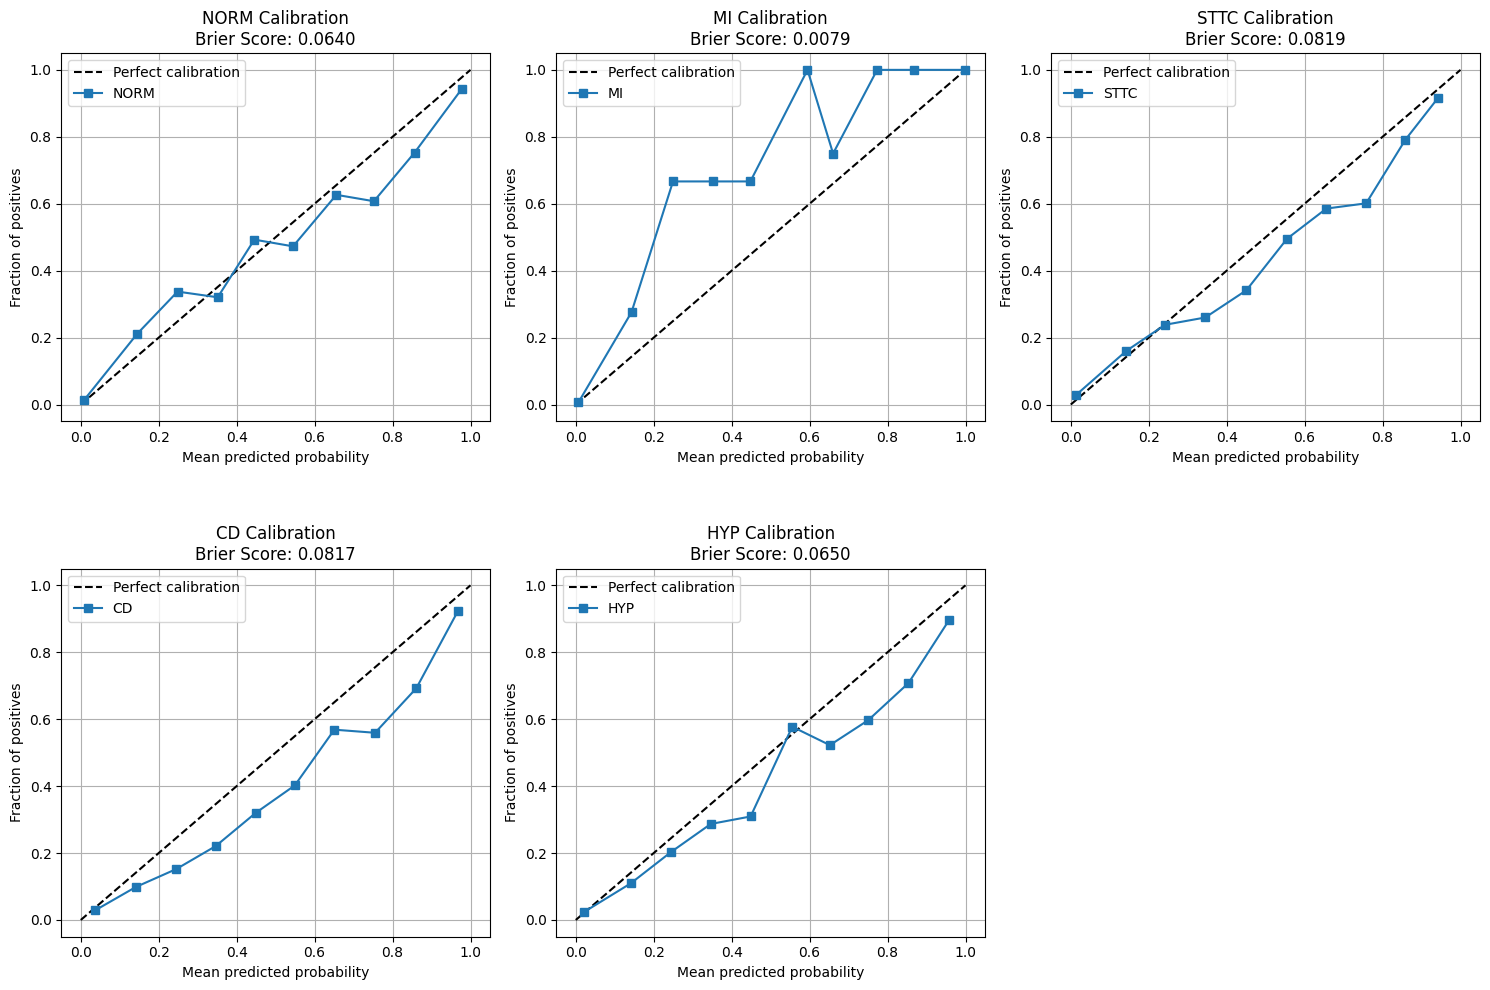

In [3]:
def plot_calibration_curves():
    """Generate calibration plots and Brier scores for clinical reliability assessment"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    calibration_data = {}

    for i, cls in enumerate(class_names):
        fraction_pos, mean_pred = calibration_curve(y_test[:, i], y_pred_proba[:, i], n_bins=10)
        brier = brier_score_loss(y_test[:, i], y_pred_proba[:, i])

        axes[i].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
        axes[i].plot(mean_pred, fraction_pos, 's-', label=f'{cls}')
        axes[i].set_xlabel('Mean predicted probability')
        axes[i].set_ylabel('Fraction of positives')
        axes[i].set_title(f'{cls} Calibration\nBrier Score: {brier:.4f}')
        axes[i].legend()
        axes[i].grid(True)

        calibration_data[cls] = {
            'mean_pred': mean_pred.tolist(),
            'fraction_pos': fraction_pos.tolist(),
            'brier_score': brier
        }

    # Remove empty subplot
    fig.delaxes(axes[5])

    # Adjust spacing
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)

    plt.savefig('calibration_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

    return calibration_data


print("\n=== Generating Calibration Analysis ===")
calibration_results = plot_calibration_curves()